# [MAC0417] Visão e Processamento de Imagens - Exercício Programa 2.2
*16 de Novembro de 2020*

## Introdução 
Na segunda parte deste exercício programa, realizamos a normalização das imagens de cada classe do *augmentedDataSet*. Usamos a equalização de histogramas como função inicial de normalização, gerando um *normalizedDataset*. Depois disso, geramos funções de análise dos *datasets* obtidos, com visualizações dos cálculos do **protótipo médio**, **histograma médio** e **variância do histograma** de cada classe.

Integrantes do grupo:

| Nome | NUSP |
|------|------|
| Daniela Favero | 10277443 |
| Mateus Barbosa | 8993368 |
| Vitor Guidi | 8038091 |

A base de dados e os metadados se encontram no nosso repositório do [GitHub](https://github.com/danigfavero/Visao-computacional-e-processamento-de-imagens).

### Organizando diretórios para o banco de imagens

Para poupar uso de internet ao executar o Notebook, vamos armazenar os resultados da *data augmentation* localmente. Para isto, primeiramente criaremos diretórios para organizar nosso banco de imagens.

O código a seguir gera (caso não existam) os diretórios que abrigarão as imagens normalizadas.

In [7]:
import os
filters = [
    "normalized_grayscale/",
    "normalized_exp/",
    "normalized_log/",
    "normalized_mean/", 
    "normalized_gradient/"
]
objs = ["colheres",
            "garfos",
            "canecas",
            "facas",
            "panelas",
            "frigideiras",
            "controles_remotos",
            "calcas",
            "casacos",
            "camisetas"]

for filt in filters:
    try:
        os.mkdir(filt)
    except FileExistsError:
        continue

for filt in filters:
    for obj in objs:
        try:
            os.mkdir(filt + obj)
        except FileExistsError:
            continue

A função `data_augmentation` abaixo é a mesma do EP2.1.

In [20]:
import matplotlib.pyplot as plt
import itertools
import numpy as np
from skimage import io
from skimage.exposure import equalize_hist
from matplotlib.pyplot import imshow

def data_augmentation(input_directory, output_directory, func):
    objs = ["colheres/COLHER",
            "garfos/GARFO",
            "canecas/CANECA",
            "facas/FACA",
            "panelas/PANELA",
            "frigideiras/FRIGIDEIRA",
            "controles_remotos/CONTROLE",
            "calcas/CALCA",
            "casacos/CASACO",
            "camisetas/CAMISETA"]
    times = ["NOITE", "DIA"]
    illums = [ "INDOOR", "OUTDOOR" ]
    backgrounds = [ "CLARO", "MADEIRA", "ESCURO" ]
    repeats = ["a", "b", "c"]
    nums = ['1', '2', '3']

    path = output_directory
    
    suffixes = list(map("".join, itertools.product(*[backgrounds, nums, repeats, [".jpg"]])))
    
    for it in itertools.product(*[objs, times, illums, suffixes]):
        suffix = "_".join(it)
        url = input_directory + suffix
        path = output_directory + suffix
        for _ in range(3): # evitando erros de conexão (3 tentativas)
            try:
                img = io.imread(url).astype(np.uint8)
                img = func(img)
                io.imsave(path, img)
            except ConnectionResetError:
                continue
            break

## Normalização das imagens

Realizamos uma normalização de histograma em todas as imagens do `augmentedDataset`,
usando a função `data_augmentation` definida acima.

In [18]:
from skimage.exposure import equalize_hist
from matplotlib.pyplot import imshow
from skimage import io

# normalizing all datasets
data_augmentation("grayscale/","normalized_grayscale/", equalize_hist)
data_augmentation("log/","normalized_log/", equalize_hist)
data_augmentation("exp/","normalized_exp/", equalize_hist)
data_augmentation("gradient/","normalized_gradient/", equalize_hist)
data_augmentation("mean/","normalized_mean/", equalize_hist)


# img_top = io.imread("~/Desktop/nova/Visao-computacional-e-processamento-de-imagens/grayscale/colheres/COLHER_DIA_INDOOR_CLARO1a.jpg").astype(np.uint8)
# imshow(equalize_hist(img_top), cmap='gray')
    

NameError: name 'data_augmentation' is not defined

## Geração de estatísticas relativas às imagens
O código a seguir gera 3 estatísticas relativas a cada classe e cada filtro em nossas *databases*: o protótipo médio (média dos níveis de cinza de cada imagem) e a média e variância dos histogramas dessas imagens.

In [21]:
import numpy as np
import functools 

def avg_prototype(input_directory):
    images, tamanho = list(get_all_images_from_folder(input_directory))
    return functools.reduce(np.add, images, np.zeros((2000,1500)) ) / tamanho
    
def generate_histograms(input_directory):
    images, tamanho = list(get_all_images_from_folder(input_directory))
    return np.array( [ hist for (hist,edges) in list( map(lambda x : np.histogram(x,bins=256), images) ) ] )

def histogram_metrics(histograms):
    return histograms.var(0), np.mean(histograms, axis=0)
    
from os import walk
from skimage.transform import resize
def get_all_images_from_folder(path):
    #tomar cuidado para usar o nome do arquivo dentro da pasta
    #walk nao retorna o path completo
    #path, ie = 'grayscale/colheres/'
    #chamar com / apos fim da pasta

    f = []
    for (dirpath, dirnames, filenames) in walk(path):
        for file in filenames:
            f.append(dirpath + file)
       
    return map(lambda x : resize(io.imread(x).astype(np.uint8), (2000,1500), anti_aliasing=True), f), len(f)

# for img in get_all_images_from_folder("grayscale/colheres/"):
#     imshow(img, cmap='gray')
# prototipo = avg_prototype("grayscale/colheres/")
#lista = generate_histograms("grayscale/colheres/")

A função `plot_stats_class` a seguir gera um gráfico contendo as 3 estatísticas geradas pelas funções acima.

In [46]:
def plot_stats_class(class_directory, filt):
    lista = generate_histograms(class_directory)
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, gridspec_kw={'width_ratios': [2, 1, 1]})
    fig.suptitle('Protótipo, Média e Variância da Classe, sob o Filtro ' + filt)
    plt.subplots_adjust(wspace=1)
    ax1.imshow(avg_prototype(class_directory), cmap='gray')
    ax2.plot([x for x in range(256)], lista[1])
    ax3.plot([x for x in range(256)], lista[0])

Finalmente, chamamos `plot_stats_class` a fim de visualizar as estatísticas de cada classe do nosso banco de imagens.

In [47]:
def plot_stats(img_class):
    filters = ['exp', 'gradient', 'grayscale', 'log', 'mean']
    norm_filters = ['normalized_exp',
                    'normalized_gradient',
                    'normalized_grayscale',
                    'normalized_log',
                    'normalized_mean']
    all_filters = [filters, norm_filters]
    for category in all_filters:
        for f in category:
            plot_stats_class(f + img_class, f.upper())

### 1. Colheres

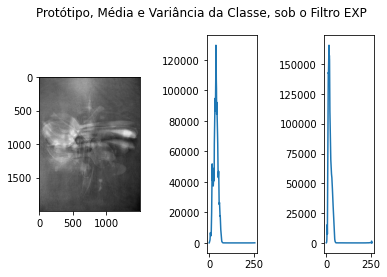

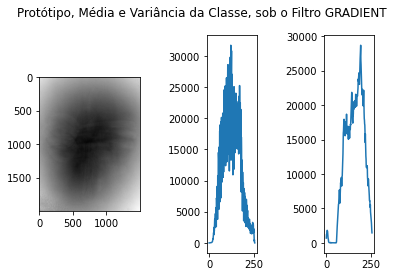

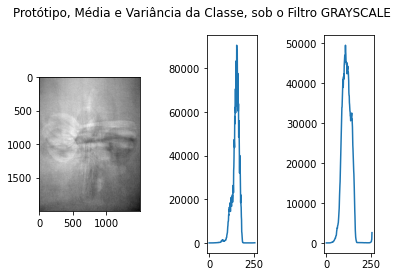

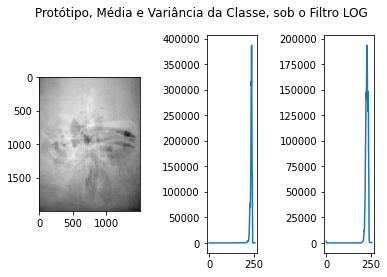

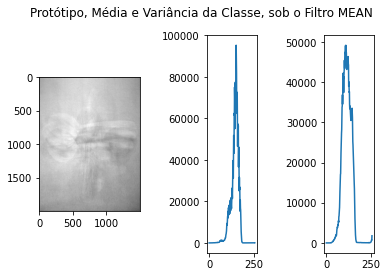

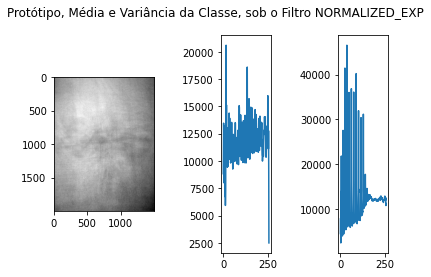

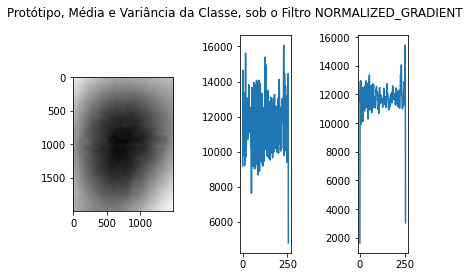

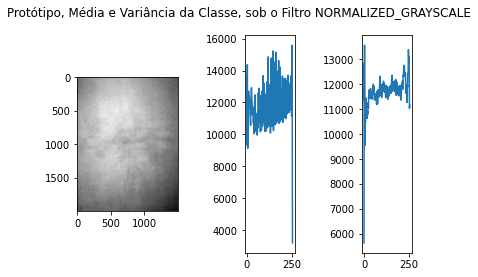

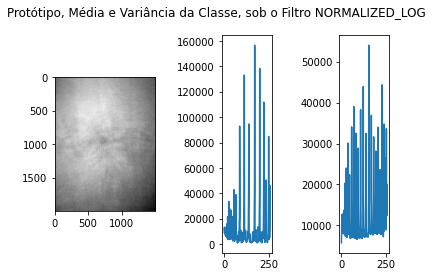

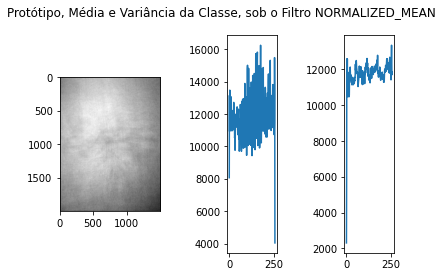

In [48]:
plot_stats("/colheres/") 

### 2. Garfos

In [ ]:
plot_stats("/garfos/") 

### 3. Canecas

In [ ]:
plot_stats("/canecas/") 

### 4. Facas

In [ ]:
plot_stats("/facas/") 

### 5. Panelas

In [ ]:
plot_stats("/panelas/") 

### 6. Frigideiras

In [ ]:
plot_stats("/frigideiras/") 

### 7. Controles Remotos

In [ ]:
plot_stats("/controles-remotos/") 

### 8. Calças

In [ ]:
plot_stats("/calcas/") 

### 9. Casacos

In [ ]:
plot_stats("/casacos/") 

###  10. Camisetas

In [ ]:
plot_stats("/camisetas/") 